## Query the Planet with EOLearn and Sentinel Data

The availability of open Earth observation (EO) data through the Copernicus and Landsat programs represents an unprecedented resource for many EO applications, ranging from ocean and land use and land cover monitoring, disaster control, emergency services and humanitarian relief. Given the large amount of high spatial resolution data at high revisit frequency, techniques able to automatically extract complex patterns in such spatio-temporal data are needed.

[`eo-learn`](https://eo-learn.readthedocs.io/en/latest/) is a collection of open source Python packages that have been developed to seamlessly access and process spatio-temporal image sequences acquired by any satellite fleet in a timely and automatic manner. eo-learn is easy to use, it’s design modular, and encourages collaboration – sharing and reusing of specific tasks in a typical EO-value-extraction workflows, such as cloud masking, image co-registration, feature extraction, classification, etc. Everyone is free to use any of the available tasks and is encouraged to improve them, develop new ones and share them with the rest of the community.

We'll walk through the basics of `eo-learn` and an example EO analysis workflow.

![eo-learn workflow](eo-learn-illustration.png)

## Boring Setup

In [1]:
# Jupyter notebook related commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# set our Sentinel Hub Instance ID (Workshop only)
# Sign-up at afterwards at https://www.sentinel-hub.com/ to continue using
!sentinelhub.config --instance_id eb3fe65f-23bf-4481-8d58-f7b8a8939b39

pyenv: sentinelhub.config: command not found

The `sentinelhub.config' command exists in these Python versions:
  3.6.8/envs/ml-inference-cfn
  3.7.2/envs/eo-learn-io
  3.7.2/envs/query-planet
  eo-learn-io
  ml-inference-cfn
  query-planet



## EO Learn Fundamentals

`eo-learn` has three fundamental classes `EOPatch`, `EOTask` and `EOWorkflow` which are helpful to understand before undertaking a larger project

### EOPatch
- an **abstract representation of remotely sensed data over a single area**; the base data class of `eo-learn`
- a collection of 10 python dicts representing various types of data along with a bounding box and timestamps
- provides useful dimension and type checking, a consistent interface for later processing, and some convenience functions

Find more details in the [documentation](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch)

In [3]:
# first create an empty patch, it is instantiated with all the data types
# each FeatureType (data, mask, scalar, ...) requires a specific type of data
from eolearn.core import EOPatch

patch = EOPatch()
patch

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

In [4]:
# the first Featuretype 'data' should be a numpy array with four dimensions, time x height x width x channel depth, to represent a time stack of remotely sensed data 

# create an example of satellite data with 5 dates, 10x10 pixels, and 3 bands
import numpy as np
example_bands = np.zeros((5, 10, 10, 3), dtype=np.uint16)
patch.data['example'] = example_bands

In [5]:
# EOPatches will throw an error if you give data of the wrong shape to a certain FeatureType

# here's satellite data with no time component
timeless_data = np.zeros((10, 10, 13), dtype=np.uint16)
try:
    patch.data['timeless_example'] = timeless_data
except ValueError as e:
    print(e)

Numpy array of FeatureType.DATA feature has to have 4 dimensions


In [6]:
# there is a different FeatureType available for data without a time component
patch.data_timeless['timeless_example'] = timeless_data

In [7]:
# try to add data to other FeatureTypes, use https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch for reference
import geopandas as gpd
from datetime import datetime
from sentinelhub import BBox, CRS

patch.mask['shadow masks'] = np.zeros((5, 6, 6, 2), dtype=np.bool)
patch.scalar['weather data'] = np.zeros((5, 3), dtype=np.float)
patch.label['classification'] = np.zeros((5, 1), dtype=np.bool)


vector = gpd.read_file('eastern_france.geojson')
vector.insert(1, 'TIMESTAMP', datetime.now())
patch.vector['land use vectors'] = vector

patch.mask_timeless['district_boundaries_raster'] = np.zeros((6, 6, 2), dtype=np.uint8)
patch.scalar_timeless['single patch value'] = np.array([5.])
patch.label_timeless['another patch value'] = np.array([True])
patch.vector_timeless['region_boundaries'] = gpd.read_file('eastern_france.geojson')

patch.meta_info = dict(any_property={ 'a': 5, 'b': 3 })
patch.bbox = BBox([24.5, 45.5, 25.5, 46.5], crs=CRS.WGS84)
patch.timestamp = [datetime.now()]

patch.get_features()

{<FeatureType.DATA: 'data'>: {'example'},
 <FeatureType.MASK: 'mask'>: {'shadow masks'},
 <FeatureType.SCALAR: 'scalar'>: {'weather data'},
 <FeatureType.LABEL: 'label'>: {'classification'},
 <FeatureType.VECTOR: 'vector'>: {'land use vectors'},
 <FeatureType.DATA_TIMELESS: 'data_timeless'>: {'timeless_example'},
 <FeatureType.MASK_TIMELESS: 'mask_timeless'>: {'district_boundaries_raster'},
 <FeatureType.SCALAR_TIMELESS: 'scalar_timeless'>: {'single patch value'},
 <FeatureType.LABEL_TIMELESS: 'label_timeless'>: {'another patch value'},
 <FeatureType.VECTOR_TIMELESS: 'vector_timeless'>: {'region_boundaries'},
 <FeatureType.META_INFO: 'meta_info'>: {'any_property'},
 <FeatureType.BBOX: 'bbox'>: True,
 <FeatureType.TIMESTAMP: 'timestamp'>: True}

In [8]:
# we can save and load our patch; check out the file structure it creates
patch.save('example_patch')
patch2 = patch.load('example_patch')
patch2.get_features()

{<FeatureType.DATA: 'data'>: {'example'},
 <FeatureType.MASK: 'mask'>: {'shadow masks'},
 <FeatureType.SCALAR: 'scalar'>: {'weather data'},
 <FeatureType.LABEL: 'label'>: {'classification'},
 <FeatureType.VECTOR: 'vector'>: {'land use vectors'},
 <FeatureType.DATA_TIMELESS: 'data_timeless'>: {'timeless_example'},
 <FeatureType.MASK_TIMELESS: 'mask_timeless'>: {'district_boundaries_raster'},
 <FeatureType.SCALAR_TIMELESS: 'scalar_timeless'>: {'single patch value'},
 <FeatureType.LABEL_TIMELESS: 'label_timeless'>: {'another patch value'},
 <FeatureType.VECTOR_TIMELESS: 'vector_timeless'>: {'region_boundaries'},
 <FeatureType.META_INFO: 'meta_info'>: {'any_property'},
 <FeatureType.BBOX: 'bbox'>: True,
 <FeatureType.TIMESTAMP: 'timestamp'>: True}

### EOTask
- an **abstract representation of an operation over remotely sensed data** over a single area; the base processing class of `eo-learn`
- must have an `execute` method which generally accepts an `EOPatch` instance as its first argument
- provides consistency of operation, chainable, predictable outputs
- many `EOTasks` are already available in the library (60+ at the time of writing)

In [16]:
# let's start with a simple one to understand the concept
# AddFeature performs the same operation we were doing before but in EOTask form
from eolearn.core import AddFeature

# specify the feature type and name, then instantiate the task (but not call it yet)
feature = (FeatureType.DATA, 'bands')
add_feature = AddFeature(feature)

# now we can execute the task, on our previous patch
data = np.zeros((5, 100, 100, 13))
patch = add_feature.execute(patch, data)
patch

EOPatch(
  data: {
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(1, 445, 476, 3), dtype=float32)
    bands: numpy.ndarray(shape=(5, 100, 100, 13), dtype=float64)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 445, 476, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    BUILDING-DATA: numpy.ndarray(shape=(445, 476, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-08-20', '2019-08-31')
  }
  bbox: BBox(((26.08, 44.42), (26.14, 44.46)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 8, 24, 9, 18, 3)]
)

In [9]:
# now let's try a more substantial task
from eolearn.io import S2L1CWCSInput

# we'll make a new empty EOPatch over the conference for this
patch = EOPatch()
patch.bbox = BBox([26.08, 44.42, 26.14, 44.46], crs=CRS.WGS84)

# now we can load Sentinel-2 data into the patch
# first instantiate the task with a Sentinel Hub layer and our desired resolution
load_s2 = S2L1CWCSInput('TRUE-COLOR-S2-L1C', resx='10m', resy='10m')

# then call the task's execute method with our patch and a time interval
load_s2.execute(eopatch=patch, time_interval=('2019-08-20', '2019-08-31'))


EOPatch(
  data: {
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(1, 445, 476, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 445, 476, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-08-20', '2019-08-31')
  }
  bbox: BBox(((26.08, 44.42), (26.14, 44.46)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 8, 24, 9, 18, 3)]
)

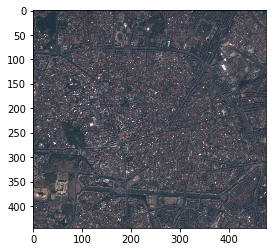

In [10]:
# since the data is a numpy array, let's try visualizing it with matplotlib
from matplotlib import pyplot as plt
plt.imshow(patch.data['TRUE-COLOR-S2-L1C'][0])

In [11]:
# try with other resolutions, date ranges or areas
# also notice the additional information that the task adds to mask, meta_info and timestamp

In [12]:
# now let's add some vector data, load a local file containing buildings
buildings = gpd.read_file('bucharest_buildings.geojson')

In [13]:
# we can add this file as either a vector (directly) or try transforming it to a raster
from eolearn.geometry import VectorToRaster
from eolearn.core import FeatureType
vtr_task = VectorToRaster(
    buildings,
    values=1,
    raster_shape=(FeatureType.DATA, 'TRUE-COLOR-S2-L1C'), # match the shape of our previous data
    raster_feature=(FeatureType.MASK_TIMELESS, 'BUILDING-DATA') # name our new layer
)

vtr_task.execute(eopatch=patch)

EOPatch(
  data: {
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(1, 445, 476, 3), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 445, 476, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    BUILDING-DATA: numpy.ndarray(shape=(445, 476, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-08-20', '2019-08-31')
  }
  bbox: BBox(((26.08, 44.42), (26.14, 44.46)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 8, 24, 9, 18, 3)]
)

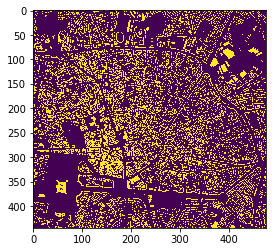

In [15]:
# now look at the buildings (also congrats, you're 50% of the way to being a geospatial machine learning engineer)
plt.imshow(patch.mask_timeless['BUILDING-DATA'].squeeze(2))